In [2]:
import pandas as pd

fpath = '/content/drive/MyDrive/criteo-uplift-v2.1.csv'
df = pd.read_csv(fpath)
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [ ]:
# Following is a detailed description of the features:

# f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)
# treatment: treatment group (1 = treated, 0 = control)
# conversion: whether a conversion occured for this user (binary, label)
# visit: whether a visit occured for this user (binary, label)
# exposure: treatment effect, whether the user has been effectively exposed (binary)

## 데이터 탐색

In [ ]:
# 데이터 분석을 진행하기 전에
# 1. 파편화 여부 확인 및 통합 - 하나의 파일로 이뤄져있다.
# 2. 결측치 확인
# 3. 범주형 변수 변환 - 특징 중에 범주형 변수는 없다. 모두 연속형 변수이다.
# 4. 라벨 변환 - 라벨로 사용하는 visit은 변환되어 있다.

In [3]:
# 2. 결측치 확인
df.isnull().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

In [ ]:
# 1. 전환 기준 설정
# 2. 테스트 캠페인 진행
# 3. 업리프트 모델링
# 4. 실전 캠페인 적용 및 평가

In [ ]:
# 1. 전환 기준 설정
# Uplift Modeling을 진행하기 전에 처치 / 전환 기준을 설정한다.

# 처치 - treatment
# 추가적으로 DataFrame에는 treatment의 exposure 여부도 포함되어있다.
# 데이터 탐색을 통해서 추가적으로 exposure가 미치는 영향도 고려한다.

# 전환 - visit

In [ ]:
# Modeling을 진행하기 전에 처치(treatment)가 전환(visit)에 미치는 영향을 평균을 통해 살펴본다.
# 처치(treatment) 유무에 따른 전환율의 차이는 1%p의 차이가 발생한다.
# 처치가 고객의 방문 여부에 긍정적인 영향을 미친다고 생각하고 분석을 진행할 수 있다.

In [4]:
df[df['treatment'] == 1]['visit'].value_counts(normalize=True)

0    0.951457
1    0.048543
Name: visit, dtype: float64

In [5]:
df[df['treatment'] == 0]['visit'].value_counts(normalize=True)

0    0.961799
1    0.038201
Name: visit, dtype: float64

In [6]:
# treatment의 노출 여부를 알려주는 exposure가 있다.
# 하지만, 탐색 결과 효과적 노출 여부는 약 3.6%만 이뤄졌다.
df[df['treatment'] == 1]['exposure'].value_counts(normalize=True)

0    0.963963
1    0.036037
Name: exposure, dtype: float64

In [ ]:
# treatment, exposure을 모두 고려해서 전환(visit)에 미치는 영향을 파악한다.
# 비교 대상 1
# A. 처치가 이뤄졌지만, 노출이 이뤄지지 않은 고객 vs B. 처치가 이뤄졌고, 노출이 이뤄진 고객
# 2개의 그룹을 대상으로 전환에 미치는 영향을 파악한다.

In [7]:
# A. 처치가 이뤄졌지만, 노출이 이뤄지지 않은 고객
df[(df['treatment'] == 1) & (df['exposure'] == 0)]['visit'].value_counts(normalize=True)

0    0.965139
1    0.034861
Name: visit, dtype: float64

In [8]:
# B. 처치가 이뤄졌고, 노출이 이뤄진 고객
df[(df['treatment'] == 1) & (df['exposure'] == 1)]['visit'].value_counts(normalize=True)

0    0.585462
1    0.414538
Name: visit, dtype: float64

In [ ]:
# exposure에 따라 고객의 전환에 미치는 영향이 매우 크다.
# 약 38%p의 차이가 발생했다.
# 기업은 처치가 이뤄지더라도 효과적 노출까지 같이 고려해야 한다는 결론을 내릴 수 있다.
# 그래서 앞서 처치는 treatment만 설정했지만, 탐색을 통해서 exposure까지 추가적으로 처치로 반영하고 분석한다.

In [ ]:
# 비교 대상 2
# A. 처치가 이뤄지지 않은 고객 vs B. 처치가 이뤄졌지만, 노출이 이뤄지지 않은 고객
# 2개의 그룹을 비교하면서 exposure가 미치는 영향에 대해 추가적으로 살펴본다.

In [9]:
# A. 처치가 이뤄지지 않은 고객
# 처치가 이뤄지지 않은 고객은 약 3.8%의 전환이 발생한다.
df[df['treatment'] == 0]['visit'].value_counts(normalize=True)

0    0.961799
1    0.038201
Name: visit, dtype: float64

In [10]:
# B. 처치가 이뤄졌지만, 노출이 이뤄지지 않은 고객
df[(df['treatment'] == 1) & (df['exposure'] == 0)]['visit'].value_counts(normalize=True)

0    0.965139
1    0.034861
Name: visit, dtype: float64

In [ ]:
# 처치가 이뤄졌지만, 노출이 이뤄지지 않은 고객에 대해서는 오히려 전환이 떨어지는 결과가 보인다.
# 기업은 효과적으로 노출이 이뤄지지 않으면, 처치 자체가 고객에게 부정적 경험을 가져다 준다는 결론을 내릴 수 있다.
# 그래서 처치 자체보다는 효과적 노출을 위한 처치를 고려해야 한다.

In [ ]:
# Uplift Modeling을 2가지 처치(treatment, exposure)에 대해서 진행할 계획이다.

## 처치 - Treatment인 경우

### 1. 전환 기준 설정

In [ ]:
# 1. 전환 기준 설정
# Uplift Modeling을 진행하기 전에 처치 / 전환 기준을 설정한다.
# 처치 - treatment
# 전환 - visit

### 2. 테스트 캠페인 진행

In [ ]:
# 2. 테스트 캠페인 진행
# 처치 - treatment
# 전환 - visit

In [11]:
# target / control 집단을 1:1로 구분지어야 한다.
# 하지만, 약 6:1의 데이터 불균형을 가지고 있다.
# 그래서 모델을 학습하기 전에 비율을 맞추기 위해 Resampling을 별도로 진행한다.
df['treatment'].value_counts(normalize=True)

1    0.85
0    0.15
Name: treatment, dtype: float64

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    df, test_size=0.2, stratify=df['treatment'])

In [ ]:
# 모델의 성능 향상을 위한 추가 데이터 탐색을 진행한다.
# 1. 특징과 라벨간의 상관 관계 확인
# 2. 이상치 제거
# 3. 특징간 관계 확인
# 4. 왜도 확인
# 5. 스케일링 진행

#### 데이터 탐색 및 전처리

##### 1. 특징과 라벨간의 상관 관계 확인

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 연속형 변수인 f0 - f11에 대해서 탐색을 진행한다.

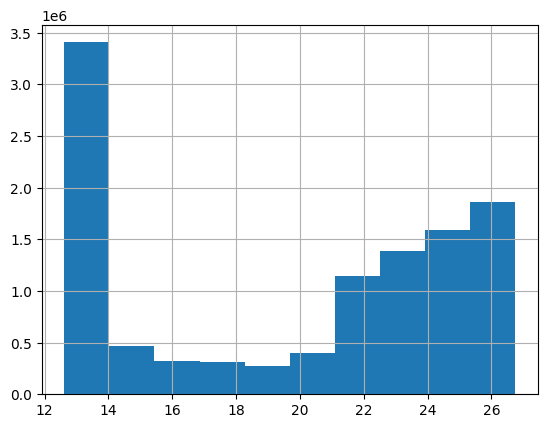

In [14]:
# f0의 분포를 보면, 일부 데이터의 밀도가 높긴 하지만 이진화처럼 범주형 변수로 변환하기에는 어려움이 있다.
train['f0'].hist()
plt.show()

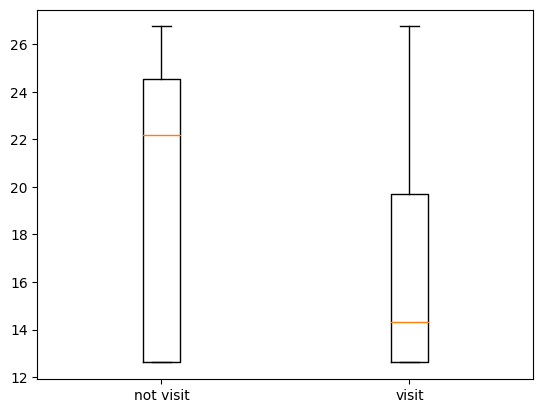

In [15]:
# f0의 경우, 전환이 이뤄지지 않을 때의 f0 IQR이 더 넓다. 그리고 평균 값이 더 크다.
# 때문에 전환에 영향을 미치는 특징이라고 판단한다.
plt.boxplot([train[train['visit'] == 0]['f0'], train[train['visit'] == 1]['f0']])
plt.xticks([1, 2], ['not visit', 'visit'])
plt.show()

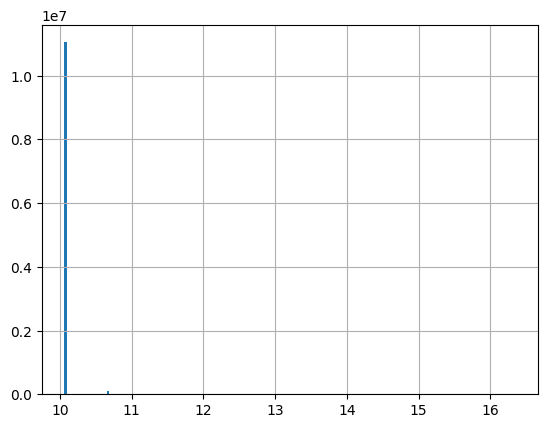

In [16]:
# f1의 분포
train['f1'].hist(bins=200)
plt.show()

In [17]:
train['f1'].describe()

count    1.118367e+07
mean     1.006998e+01
std      1.047974e-01
min      1.005965e+01
25%      1.005965e+01
50%      1.005965e+01
75%      1.005965e+01
max      1.634419e+01
Name: f1, dtype: float64

In [18]:
# 특정 수치에 몰려있다.
# 그래서 가장 많이 나타나는 값과 아닌 값으로 이진화할 때, 전환율에 영향을 주는지 확인한다.
train['f1'].value_counts()

10.059654    11046152
10.679513       98440
11.119309       21488
11.460441        7650
11.739167        3745
11.974826        1947
12.178963        1205
12.359025         783
12.520096         537
12.665802         389
12.798822         278
12.921188         211
13.034481         156
13.139954         122
13.238618         120
13.331298          67
13.418680          56
13.501335          45
13.579750          43
13.725457          31
13.654339          30
13.793413          26
13.920883          17
13.858476          15
14.094135          15
14.147781          12
14.038538          12
13.980842           9
14.199609           7
14.435268           7
14.298272           7
14.390953           6
14.345315           5
14.600700           5
14.785111           3
14.249736           3
14.520221           3
14.713993           2
14.478334           2
14.560990           2
14.980537           2
15.126244           2
15.259263           2
14.639405           2
15.600396           1
14.677154 

In [19]:
f1_frequent_value = train['f1'].value_counts().index[0]
f1_frequent_value

10.059654474774549

In [20]:
train['f1_frequent'] = (train['f1'] == f1_frequent_value).astype(int)
train['f1_frequent'].value_counts()

1    11046152
0      137521
Name: f1_frequent, dtype: int64

In [21]:
# f1 frequent value가 전환에 미치는 영향을 살펴본다.
# 자주 나타나는 값이냐 아니냐에 따라 전환에 미치는 영향이 크다.
# f1을 자주 나타나는 값이냐 아니냐의 이진화 변수로 변환한다.
train.groupby(['f1_frequent'])['visit'].mean()

f1_frequent
0    0.259553
1    0.044354
Name: visit, dtype: float64

In [22]:
test['f1_frequent'] = (test['f1'] == f1_frequent_value).astype(int)
test['f1_frequent'].value_counts()

1    2761490
0      34429
Name: f1_frequent, dtype: int64

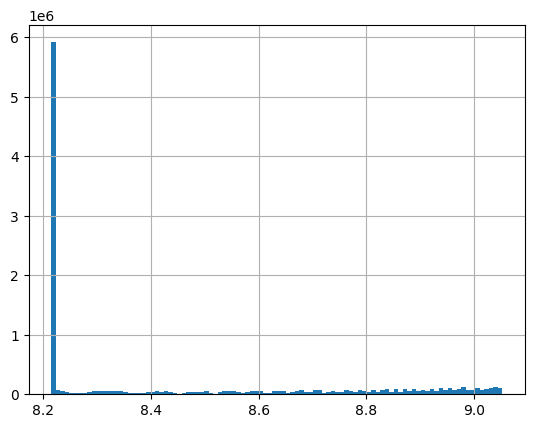

In [23]:
# f2의 분포
train['f2'].hist(bins=100)
plt.show()

In [24]:
train['f2'].value_counts()

8.214383    5842609
8.214386        135
8.214388        124
8.214390        122
8.214392         99
             ...   
8.929810          1
8.563050          1
8.887571          1
8.704769          1
8.798333          1
Name: f2, Length: 1926197, dtype: int64

In [25]:
f2_frequent_value = train['f2'].value_counts().index[0]
f2_frequent_value

8.214382844395335

In [26]:
train['f2_frequent'] = (train['f2'] == f2_frequent_value).astype(int)
train['f2_frequent'].value_counts()

1    5842609
0    5341064
Name: f2_frequent, dtype: int64

In [27]:
# f2 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f2_frequent'])['visit'].mean()

f2_frequent
0    0.096873
1    0.001409
Name: visit, dtype: float64

In [28]:
test['f2_frequent'] = (test['f2'] == f2_frequent_value).astype(int)
test['f2_frequent'].value_counts()

1    1460820
0    1335099
Name: f2_frequent, dtype: int64

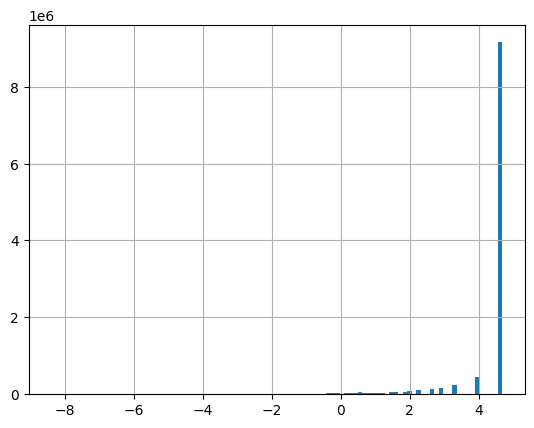

In [29]:
# f3의 분포
train['f3'].hist(bins=100)
plt.show()

In [30]:
train['f3'].value_counts()

 4.679882    9154631
 3.907662     459059
 3.359763     247507
 2.934780     171705
 2.587543     129558
              ...   
-8.376438          1
-6.151124          1
-5.766069          1
-5.494745          1
-5.635235          1
Name: f3, Length: 533, dtype: int64

In [31]:
f3_frequent_value = train['f3'].value_counts().index[0]
f3_frequent_value

4.679881620097284

In [32]:
train['f3_frequent'] = (train['f3'] == f3_frequent_value).astype(int)
train['f3_frequent'].value_counts()

1    9154631
0    2029042
Name: f3_frequent, dtype: int64

In [33]:
# f3 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f3_frequent'])['visit'].mean()

f3_frequent
0    0.125144
1    0.029681
Name: visit, dtype: float64

In [34]:
test['f3_frequent'] = (test['f3'] == f3_frequent_value).astype(int)
test['f3_frequent'].value_counts()

1    2289364
0     506555
Name: f3_frequent, dtype: int64

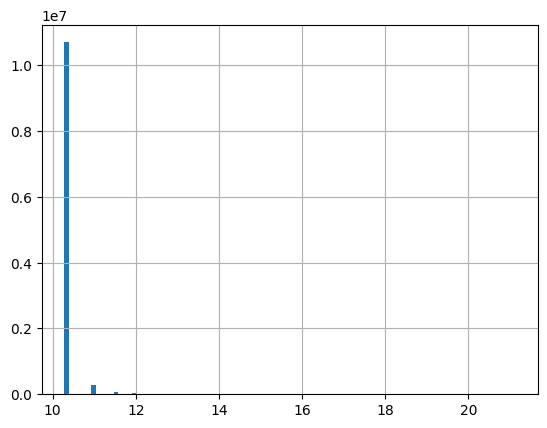

In [35]:
# f4의 분포
train['f4'].hist(bins=100)
plt.show()

In [36]:
train['f4'].value_counts()

10.280525    10697778
11.029584      278166
11.561050       79173
11.973287       36627
12.310110       20789
               ...   
18.634111           1
19.314992           1
19.200388           1
19.038298           1
19.356200           1
Name: f4, Length: 242, dtype: int64

In [37]:
f4_frequent_value = train['f4'].value_counts().index[0]
f4_frequent_value

10.280525225748212

In [38]:
train['f4_frequent'] = (train['f4'] == f4_frequent_value).astype(int)
train['f4_frequent'].value_counts()

1    10697778
0      485895
Name: f4_frequent, dtype: int64

In [39]:
# f4 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f4_frequent'])['visit'].mean()

f4_frequent
0    0.315052
1    0.034826
Name: visit, dtype: float64

In [40]:
test['f4_frequent'] = (test['f4'] == f4_frequent_value).astype(int)
test['f4_frequent'].value_counts()

1    2674917
0     121002
Name: f4_frequent, dtype: int64

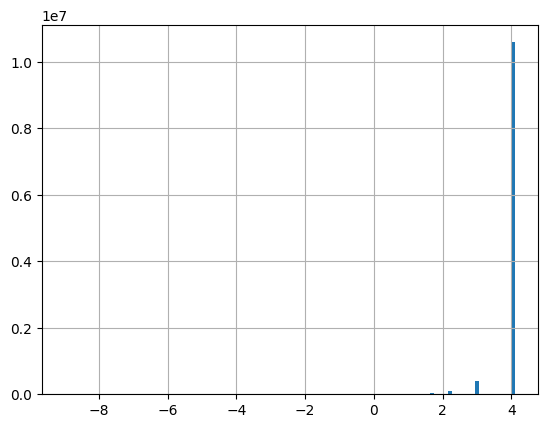

In [41]:
# f5의 분포
train['f5'].hist(bins=100)
plt.show()

In [42]:
train['f5'].value_counts()

 4.115453    10590641
 3.013064      386718
 2.230907      100394
 1.624218       41314
 1.128518       20963
               ...   
-6.779788           1
-6.409669           1
-7.149009           1
-9.011892           1
-6.900645           1
Name: f5, Length: 121, dtype: int64

In [43]:
f5_frequent_value = train['f5'].value_counts().index[0]
f5_frequent_value

4.115453421277861

In [44]:
train['f5_frequent'] = (train['f5'] == f5_frequent_value).astype(int)
train['f5_frequent'].value_counts()

1    10590641
0      593032
Name: f5_frequent, dtype: int64

In [45]:
# f5 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f5_frequent'])['visit'].mean()

f5_frequent
0    0.156121
1    0.040890
Name: visit, dtype: float64

In [46]:
test['f5_frequent'] = (test['f5'] == f5_frequent_value).astype(int)
test['f5_frequent'].value_counts()

1    2647508
0     148411
Name: f5_frequent, dtype: int64

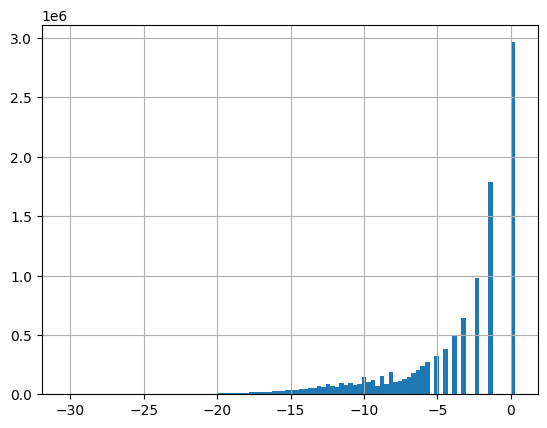

In [47]:
# f6의 분포
train['f6'].hist(bins=100)
plt.show()

In [48]:
# 이전에 진행했던 f 특징들과 다르게 데이터가 분포되어있다.
# 그래서 앞선 경우처럼 이진화를 진행하기에는 어려움이 있다.
train['f6'].value_counts()

 0.294443     2964467
-1.288207     1785581
-2.411115      979917
-3.282109      644882
-3.993764      495626
               ...   
-25.214526          1
-25.768178          1
-26.780143          1
-25.589638          1
-24.684401          1
Name: f6, Length: 1581, dtype: int64

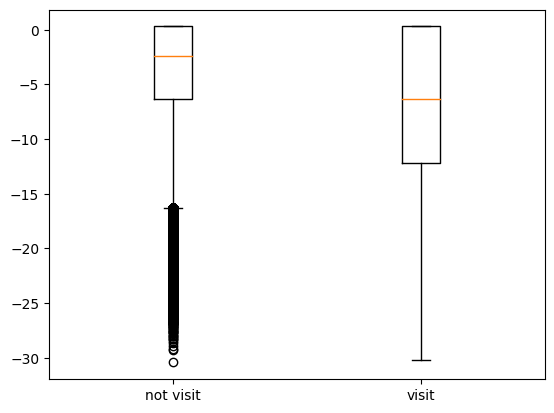

In [49]:
# f6의 경우, IQR 기준으로 전환이 이뤄지지 않은 f6의 이상치 값이 많다.
# 또한 전환이 이뤄지지 않은 경우에 평균이 낮고, 더 좁은 IQR 범위를 가지고 있다.
# 구분될 수 있는 특징이라 판단한다.
plt.boxplot([train[train['visit'] == 0]['f6'], train[train['visit'] == 1]['f6']])
plt.xticks([1, 2], ['not visit', 'visit'])
plt.show()

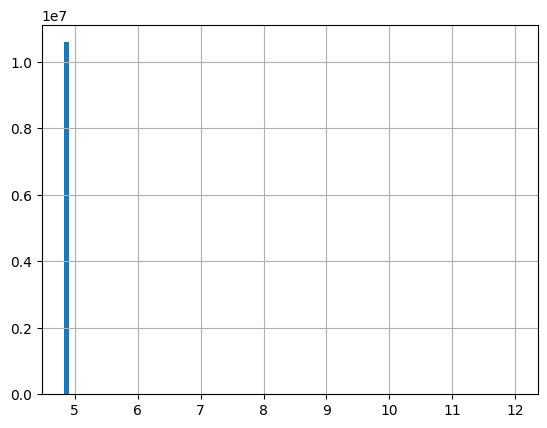

In [50]:
# f7의 분포
train['f7'].hist(bins=100)
plt.show()

In [51]:
train['f7'].value_counts()

4.833815     10590641
6.535635            6
11.795179           6
8.414089            5
9.938365            5
               ...   
11.289684           1
11.773978           1
10.863520           1
6.228651            1
11.889625           1
Name: f7, Length: 514878, dtype: int64

In [52]:
f7_frequent_value = train['f7'].value_counts().index[0]
f7_frequent_value

4.833814577796811

In [53]:
train['f7_frequent'] = (train['f7'] == f7_frequent_value).astype(int)
train['f7_frequent'].value_counts()

1    10590641
0      593032
Name: f7_frequent, dtype: int64

In [54]:
# f7 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f7_frequent'])['visit'].mean()

f7_frequent
0    0.156121
1    0.040890
Name: visit, dtype: float64

In [55]:
test['f7_frequent'] = (test['f7'] == f7_frequent_value).astype(int)
test['f7_frequent'].value_counts()

1    2647508
0     148411
Name: f7_frequent, dtype: int64

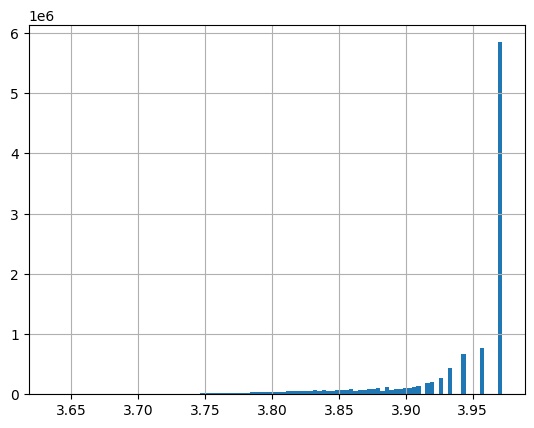

In [56]:
# f8의 분포
train['f8'].hist(bins=100)
plt.show()

In [57]:
# 이전에 진행했던 f 특징들과 다르게 데이터가 분포되어있다.
# 그래서 앞선 경우처럼 이진화를 진행하기에는 어려움이 있다.
train['f8'].value_counts()

3.971858    5842609
3.955396     765094
3.943716     665102
3.934656     428049
3.927254     271340
             ...   
3.651270          1
3.671764          1
3.668808          1
3.673398          1
3.667469          1
Name: f8, Length: 3600, dtype: int64

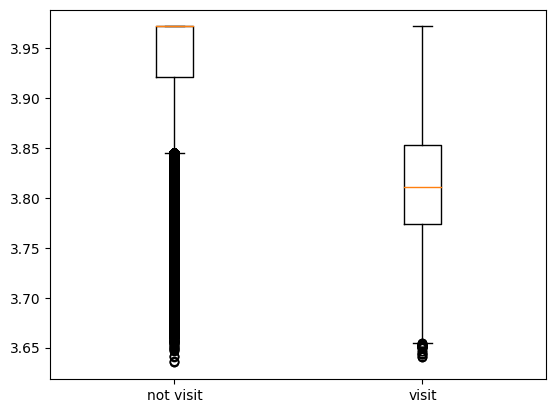

In [58]:
# f8의 경우, IQR 기준으로 전환이 이뤄지지 않은 f8의 이상치 값이 많다.
# 또한 전환이 이뤄지지 않은 경우에 평균이 낮고, 더 좁은 IQR 범위를 가지고 있다.
# 구분될 수 있는 특징이라 판단한다.
plt.boxplot([train[train['visit'] == 0]['f8'], train[train['visit'] == 1]['f8']])
plt.xticks([1, 2], ['not visit', 'visit'])
plt.show()

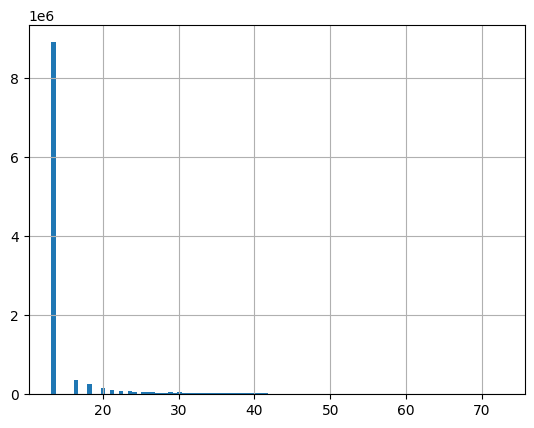

In [59]:
# f9의 분포
train['f9'].hist(bins=100)
plt.show()

In [60]:
train['f9'].value_counts()

13.190056    8891159
16.226044     363850
18.380112     271918
20.050937     159278
21.416100     112699
              ...   
63.195264          1
67.718380          1
62.052799          1
63.004485          1
62.322169          1
Name: f9, Length: 1524, dtype: int64

In [61]:
f9_frequent_value = train['f9'].value_counts().index[0]
f9_frequent_value

13.190055934673358

In [62]:
train['f9_frequent'] = (train['f9'] == f9_frequent_value).astype(int)
train['f9_frequent'].value_counts()

1    8891159
0    2292514
Name: f9_frequent, dtype: int64

In [63]:
# f9 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f9_frequent'])['visit'].mean()

f9_frequent
0    0.201593
1    0.007140
Name: visit, dtype: float64

In [64]:
test['f9_frequent'] = (test['f9'] == f9_frequent_value).astype(int)
test['f9_frequent'].value_counts()

1    2222176
0     573743
Name: f9_frequent, dtype: int64

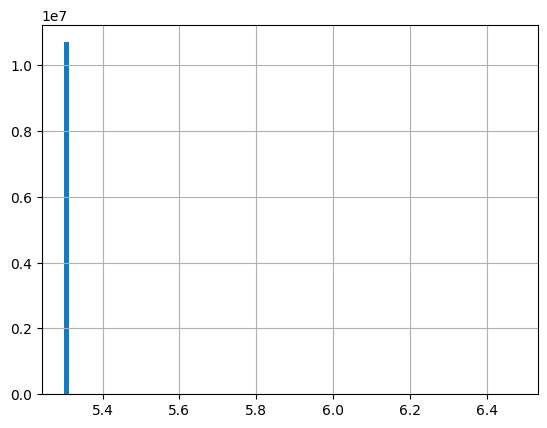

In [65]:
# f10의 분포
train['f10'].hist(bins=100)
plt.show()

In [66]:
train['f10'].value_counts()

5.300375    10697778
6.318295           9
6.200077           8
6.443298           7
5.949928           7
              ...   
5.317781           1
6.030967           1
6.469138           1
5.988036           1
6.289290           1
Name: f10, Length: 426685, dtype: int64

In [67]:
f10_frequent_value = train['f10'].value_counts().index[0]
f10_frequent_value

5.300374864042156

In [68]:
train['f10_frequent'] = (train['f10'] == f10_frequent_value).astype(int)
train['f10_frequent'].value_counts()

1    10697778
0      485895
Name: f10_frequent, dtype: int64

In [69]:
# f10 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f10_frequent'])['visit'].mean()

f10_frequent
0    0.315052
1    0.034826
Name: visit, dtype: float64

In [70]:
test['f10_frequent'] = (test['f10'] == f10_frequent_value).astype(int)
test['f10_frequent'].value_counts()

1    2674917
0     121002
Name: f10_frequent, dtype: int64

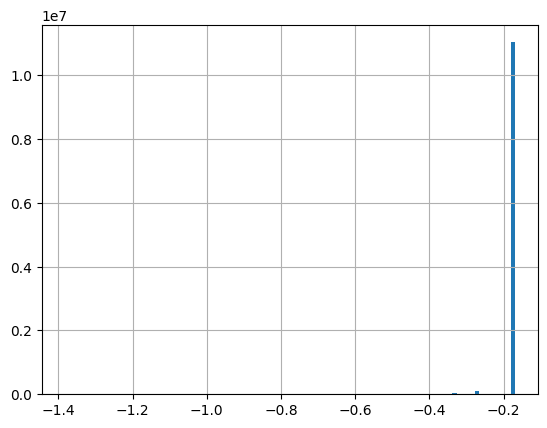

In [71]:
# f11의 분포
train['f11'].hist(bins=100)
plt.show()

In [72]:
train['f11'].value_counts()

-0.168679    11021753
-0.267350      102668
-0.337358       24694
-0.391661       10983
-0.436029        6227
               ...   
-1.182648           1
-1.123102           1
-1.053896           1
-1.283199           1
-1.081131           1
Name: f11, Length: 127, dtype: int64

In [73]:
f11_frequent_value = train['f11'].value_counts().index[0]
f11_frequent_value

-0.1686792210005612

In [74]:
train['f11_frequent'] = (train['f11'] == f11_frequent_value).astype(int)
train['f11_frequent'].value_counts()

1    11021753
0      161920
Name: f11_frequent, dtype: int64

In [75]:
# f11 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f11_frequent'])['visit'].mean()

f11_frequent
0    0.450068
1    0.041079
Name: visit, dtype: float64

In [76]:
test['f11_frequent'] = (test['f11'] == f11_frequent_value).astype(int)
test['f11_frequent'].value_counts()

1    2755453
0      40466
Name: f11_frequent, dtype: int64

In [ ]:
# 연속형 변수 f0 - f11 까지의 탐색 결과
# f0, f6, f8은 연속형 변수 유지
# 나머지 f(1, 2, 3, 4, 5, 7, 9, 10, 11)는 이진형 변수로 변환한다.

In [77]:
(train.shape, test.shape)

((11183673, 25), (2795919, 25))

In [78]:
drop_feature_list = ['f1', 'f2', 'f3', 'f4', 'f5', 'f7', 'f9', 'f10', 'f11']
train = train.drop(drop_feature_list, axis=1)
test = test.drop(drop_feature_list, axis=1)

In [79]:
train.head()

,f0,f6,f8,treatment,conversion,visit,exposure,f1_frequent,f2_frequent,f3_frequent,f4_frequent,f5_frequent,f7_frequent,f9_frequent,f10_frequent,f11_frequent
9120447,24.868060,-5.576414,3.971858,1,0,0,0,1,1,1,1,1,1,1,1,1
12742171,12.616365,0.294443,3.955396,0,0,0,0,1,0,1,1,1,1,1,1,1
1606648,24.387039,-9.404879,3.971858,1,0,0,0,1,1,1,1,1,1,1,1,1
562940,24.850906,-2.411115,3.971858,1,0,0,0,1,1,1,1,1,1,1,1,1
248997,23.752061,-3.993764,3.971858,1,0,0,0,1,1,1,1,1,1,1,1,1


In [80]:
test.head()

,f0,f6,f8,treatment,conversion,visit,exposure,f1_frequent,f2_frequent,f3_frequent,f4_frequent,f5_frequent,f7_frequent,f9_frequent,f10_frequent,f11_frequent
13080994,12.616365,0.294443,3.745781,0,0,0,0,1,0,1,1,1,1,0,1,1
230706,26.312781,-2.411115,3.971858,1,0,0,0,1,1,1,1,1,1,1,1,1
2280866,23.937903,-6.359690,3.927254,1,0,0,0,1,0,1,1,1,1,1,1,1
3845433,26.213997,-1.288207,3.971858,1,0,0,0,1,1,1,1,1,1,1,1,1
11967307,18.098345,-3.993764,3.971858,1,0,0,0,1,1,0,1,1,1,1,1,1


##### 2. 이상치 제거

In [ ]:
# (*) TODO. DBSCAN은 memory error로 인해서 진행할 수 없다.
# 개별 feature에 대해서 IQR을 진행할 수도 있지만, 연속형 변수가 3개이기 때문에 이상치 제거를 위해서는 DBSCAN이 더 낫다고 판단한다.
# 해결 방법에 대해서 고민해야 한다.

In [81]:
import numpy as np

def IQR_rule(val_list, w=1.5):
    Q1 = np.quantile(val_list, 0.25)
    Q3 = np.quantile(val_list, 0.75)
    IQR = Q3 - Q1

    not_outlier_cond = (Q3 + w * IQR > val_list) & (Q1 - w * IQR < val_list)
    return not_outlier_cond

##### 3. 특징간 관계 확인

In [82]:
# 연속형 변수 중에서 (f0, f8)만이 "0.4" 정도의 선형 상관성이 보인다.
# 큰 수치가 아니라 판단하고, 탐색을 계속해서 진행한다.

train[['f0', 'f6', 'f8']].corr(method='pearson')

,f0,f6,f8
f0,1.000000,-0.270595,0.404841
f6,-0.270595,1.000000,0.119003
f8,0.404841,0.119003,1.000000


##### 4. 왜도 확인

In [83]:
# "f8"만 왜도 치우침의 기준인 1.5를 넘었다.
# 그래서 해당 특징에 대해서 변환을 통해 치우침을 줄인다.
train[['f0', 'f6', 'f8']].skew()

f0   -0.245727
f6   -1.135498
f8   -1.605279
dtype: float64

In [84]:
# log(x - x.min() + 1)
np.log(train['f8'] - train['f8'].min() + 1).skew()

-1.6971368100075295

In [85]:
# sqrt(x - x.min())
np.sqrt(train['f8'] - train['f8'].min()).skew()

-1.9013259979796489

In [ ]:
# log(x - x.min() + 1) / sqrt(x - x.min())
# 변환을 했지만, 오히려 왜도가 더 커졌다.
# 그래서 변환을 진행하지 않고, 판단의 기준인 1.5를 크게 넘어서지 않은 수치라서 그대로 유지한다.

##### 5. 스케일링

In [86]:
# f0, f6, f8 사이에 스케일 차이가 아래와 같이 발생한다.
# 그래서 추가적으로 스케일링 작업을 진행한다.
train[['f0', 'f6', 'f8']].max() - train[['f0', 'f6', 'f8']].min()

f0    14.128890
f6    30.713604
f8     0.336751
dtype: float64

In [87]:
# 특징간 scale 차이가 크게 발생하기 때문에 이를 줄이기 위한 Min Max Scaler를 진행한다.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train[['f0', 'f6', 'f8']])

train[['f0', 'f6', 'f8']] = scaler.transform(train[['f0', 'f6', 'f8']])
train[['f0', 'f6', 'f8']].max() - train[['f0', 'f6', 'f8']].min()

f0    1.0
f6    1.0
f8    1.0
dtype: float64

In [88]:
test[['f0', 'f6', 'f8']] = scaler.transform(test[['f0', 'f6', 'f8']])

#### 타겟군 / 대조군 데이터 분할

In [89]:
# Uplift Modeling을 진행하기 위해서는 target(실험군) / control(대조군)의 비율이 1:1이 되어야 한다.
# 하지만, 현재 train dataset은 비율이 1:1이 아니다. 동일한 데이터셋을 맞추기 위해 언더 샘플링을 진행해야 한다.
train['treatment'].value_counts()

1    9506123
0    1677550
Name: treatment, dtype: int64

In [90]:
under_sample = train['treatment'].value_counts().iloc[1]
under_sample

1677550

In [91]:
train_treatment = train[train['treatment'] == 1]
train_control = train[train['treatment'] == 0]

In [92]:
train_treatment_undersample = train_treatment.sample(under_sample)
train_treatment_undersample.shape

(1677550, 16)

In [93]:
train_control.shape

(1677550, 16)

In [ ]:
# 타겟군 학습 데이터 - train_treatment_undersample
# 대조군 학습 데이터 - train_control

In [94]:
# 타겟군 학습 데이터 생성
train_treatment_x = train_treatment_undersample.drop(['treatment', 'conversion', 'visit', 'exposure'], axis=1)
train_treatment_y = train_treatment_undersample['visit']

In [95]:
# 대조군 학습 데이터 생성
train_control_x = train_control.drop(['treatment', 'conversion', 'visit', 'exposure'], axis=1)
train_control_y = train_control['visit']

### 3. 업리프트 모델링

In [ ]:
# Two Model Approaches 를 사용하여, 타겟군 / 대조군 데이터를 각각 학습시켜 독립적인 두 모델을 생성한다.
# 학습이 모두 마무리되면, 결과값을 조합하여 최종 결과값을 산출한다.

In [96]:
train_control_x.shape

(1677550, 12)

In [97]:
train_control_x.head()

,f0,f6,f8,f1_frequent,f2_frequent,f3_frequent,f4_frequent,f5_frequent,f7_frequent,f9_frequent,f10_frequent,f11_frequent
12742171,0.000000,1.000000,0.951115,1,0,1,1,1,1,1,1,1
5670446,0.000000,1.000000,0.951115,1,0,1,1,1,1,0,1,1
8223710,0.000000,1.000000,0.916431,1,0,1,1,1,1,0,1,1
5683770,0.958697,0.911910,1.000000,1,1,1,1,1,1,1,1,1
12593830,0.886566,0.883552,1.000000,1,1,1,1,1,1,1,1,1


In [98]:
int(1677550 / 12)

139795

In [ ]:
# 특징 대비 샘플수가 충분하다. 139795 : 1
# 이진형과 연속형 데이터가 섞여있다.
# uplift score를 계산하기 위해 개별 클래스의 확률(predict_proba)을 출력하는 모델이어야 한다.
# > 그래서 적당한 복잡도를 가지는 LGBM 모델을 사용한다.

In [99]:
from lightgbm import LGBMClassifier

target_lgbm_model = LGBMClassifier(random_state=28)
target_lgbm_model.fit(train_treatment_x, train_treatment_y)

control_lgbm_model = LGBMClassifier(random_state=28)
control_lgbm_model.fit(train_control_x, train_control_y)

LGBMClassifier(random_state=28)

### 4. 실전 캠페인 적용 및 평가

In [100]:
import numpy as np
import pandas as pd

def set_group(score):
    if score < -0.1:
        group = 'sleeping dogs'
    elif score >= -0.1 and score < 0:
        group = 'lost causes'
    elif score >= 0 and score < 0.1:
        group = 'sure things'
    else:
        group = 'persuables'

    return group

def model_predict_conversion(prob):
    if prob >= 0.5:
        return 'visit'
    else:
        return 'not visit'

def get_result_df(test):
    drop_list = ['treatment', 'conversion', 'visit', 'exposure']
    test_x = test.drop(drop_list, axis=1)

    target_result = target_lgbm_model.predict_proba(test_x)[:, 1]
    control_result = control_lgbm_model.predict_proba(test_x)[:, 1]
    uplift_score_list = target_result - control_result

    result_df = pd.DataFrame({
    'user_id':test_x.index,
    'target_model_proba':target_result,
    'control_model_proba':control_result,
    'uplift_score':uplift_score_list})

    result_df['group'] = result_df['uplift_score'].apply(set_group)
    
    result_df['target_model_pred'] = result_df['target_model_proba'].apply(model_predict_conversion)
    result_df['control_model_pred'] = result_df['control_model_proba'].apply(model_predict_conversion)

    return result_df

def get_eval_df(result_df):
    # audience size
    eval_df = pd.DataFrame(result_df.groupby(['group'])['group'].count())
    eval_df.rename({'group':'audience_size'}, axis=1, inplace=True)

    # target model conversion prediction
    temp_df = result_df.groupby(['group'], as_index=False)['target_model_pred'].value_counts()
    temp_df = temp_df[temp_df['target_model_pred'] == 'visit']
    temp_df.rename({'count':'target_conversion_count'}, axis=1, inplace=True)
    temp_df = temp_df.set_index('group')

    # join eval_df / target model conversion prediction df
    eval_df = pd.concat([eval_df, temp_df['target_conversion_count']], axis=1)
    eval_df = eval_df.replace(np.nan, 0)
    eval_df['target_conversion_count'] = eval_df['target_conversion_count'].astype(int)

    # control model conversion prediction
    temp_df = result_df.groupby(['group'], as_index=False)['control_model_pred'].value_counts()
    temp_df = temp_df[temp_df['control_model_pred'] == 'visit']
    temp_df.rename({'count':'control_conversion_count'}, axis=1, inplace=True)
    temp_df = temp_df.set_index('group')

    # join eval_df / control model conversion prediction df
    eval_df = pd.concat([eval_df, temp_df['control_conversion_count']], axis=1)
    eval_df = eval_df.replace(np.nan, 0)
    eval_df['control_conversion_count'] = eval_df['control_conversion_count'].astype(int)

    # prediction difference between target and control
    eval_df['pred_diff'] = eval_df['target_conversion_count'] - eval_df['control_conversion_count']

    return eval_df

def not_apply_uplift(eval_df, cost_per_person, revenue_per_person):
    # 광고비
    num_people = eval_df['audience_size'].sum()
    ad_cost = num_people * cost_per_person

    # 전환수.
    conversion_count = eval_df['target_conversion_count'].sum()

    # 수익.
    revenue = conversion_count * revenue_per_person

    # 손실. 
    loss = eval_df[eval_df['pred_diff'] < 0]['pred_diff'].sum() * revenue_per_person
    loss = -loss

    # 이익
    profit = revenue - (ad_cost + loss)

    # ROAS
    roas = round(revenue * 100 / ad_cost)

    # ROI
    roi = round(profit * 100 / ad_cost)

    # 1인당 전환 단가
    conversion_cost_per_person = ad_cost / conversion_count

    result = [ad_cost, conversion_count, revenue, loss, profit, roas, roi, conversion_cost_per_person]
    return result

def apply_uplift(eval_df, cost_per_person, revenue_per_person):
    # 광고비
    num_people = eval_df.loc['persuables', 'audience_size']
    ad_cost = num_people * cost_per_person

    # 전환수.
    conversion_count = eval_df.loc['persuables', 'target_conversion_count']

    # 수익.
    revenue = conversion_count * revenue_per_person

    # 손실. 
    loss = 0

    # 이익
    profit = revenue - (ad_cost + loss)

    # ROAS
    roas = round(revenue * 100 / ad_cost)

    # ROI
    roi = round(profit * 100 / ad_cost)

    # 1인당 전환 단가
    conversion_cost_per_person = ad_cost / conversion_count

    result = [ad_cost, conversion_count, revenue, loss, profit, roas, roi, conversion_cost_per_person]
    return result

def get_eval_table(eval_df, cost_per_person, revenue_per_person):
    not_apply_list = not_apply_uplift(eval_df, cost_per_person, revenue_per_person)
    apply_list = apply_uplift(eval_df, cost_per_person, revenue_per_person)

    index_list = ['광고비', '전환수', '수익', '손실', '이익', 'ROAS', 'ROI', '1인당 전환 단가']
    eval_table = pd.DataFrame({'not_uplift':not_apply_list,
                               'uplift':apply_list},
                              index=index_list)
    
    return eval_table

In [101]:
result_df = get_result_df(test)
result_df.head()

,user_id,target_model_proba,control_model_proba,uplift_score,group,target_model_pred,control_model_pred
0,13080994,0.551444,0.525972,0.025472,sure things,visit,visit
1,230706,0.000487,0.000393,0.000094,sure things,not visit,not visit
2,2280866,0.015060,0.012241,0.002820,sure things,not visit,not visit
3,3845433,0.000496,0.000363,0.000134,sure things,not visit,not visit
4,11967307,0.002122,0.001792,0.000330,sure things,not visit,not visit


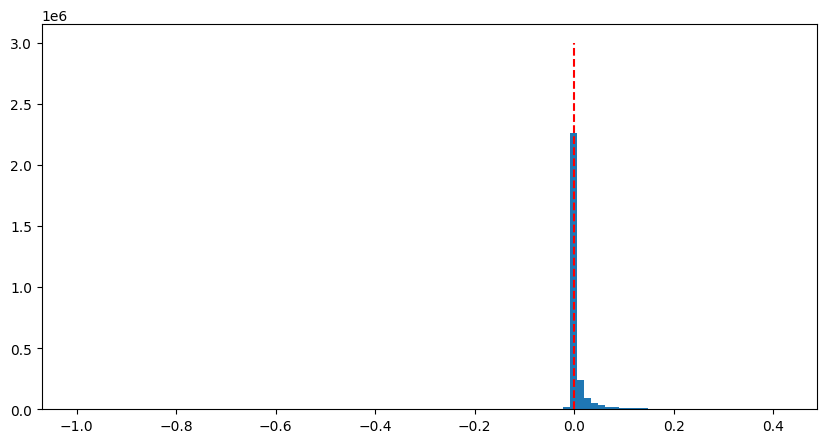

In [102]:
plt.hist(result_df['uplift_score'], bins=100)
plt.vlines(0, ymin=0, ymax=3000000, colors='r', linestyles='dashed')
plt.gcf().set_size_inches(10, 5)
plt.show()

In [103]:
eval_df = get_eval_df(result_df)
eval_df

,audience_size,target_conversion_count,control_conversion_count,pred_diff
group,,,,
lost causes,332184,6625,6716,-91
persuables,52884,20147,4894,15253
sleeping dogs,485,134,167,-33
sure things,2410366,30550,22801,7749


In [104]:
pd.options.display.float_format = '{:.1f}'.format

cost_per_person = 100
revenue_per_person = 1000

eval_table = get_eval_table(
    eval_df, 
    cost_per_person, 
    revenue_per_person)

eval_table

,not_uplift,uplift
광고비,279591900.0,5288400.0
전환수,57456.0,20147.0
수익,57456000.0,20147000.0
손실,124000.0,0.0
이익,-222259900.0,14858600.0
ROAS,21.0,381.0
ROI,-79.0,281.0
1인당 전환 단가,4866.2,262.5


In [105]:
eval_df.to_csv('treatment_eval_df.csv')
eval_table.to_csv('treatment_eval_table.csv')

## 처치 - Exposure인 경우

### 1. 전환 기준 설정

In [ ]:
# 1. 전환 기준 설정
# Uplift Modeling을 진행하기 전에 처치 / 전환 기준을 설정한다.
# 처치 - exposure
# 전환 - visit

### 2. 테스트 캠페인 진행

In [ ]:
# 2. 테스트 캠페인 진행
# 처치 - exposure
# 전환 - visit

In [106]:
# target / control 집단을 1:1로 구분지어야 한다.
# 하지만, 데이터 불균형을 가지고 있다.
# 그래서 모델을 학습하기 전에 비율을 맞추기 위해 Resampling을 별도로 진행한다.
df['exposure'].value_counts(normalize=True)

0   1.0
1   0.0
Name: exposure, dtype: float64

In [107]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    df, test_size=0.2, stratify=df['exposure'])

In [ ]:
# 앞서 Treatment에서 진행했던 데이터에 대한 탐색 및 전처리는 동일하게 진행한다.

#### 데이터 탐색 및 전처리

##### 1. 특징과 라벨간의 상관 관계 확인

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

In [109]:
# 연속형 변수인 f0 - f11에 대해서 탐색을 진행한다.

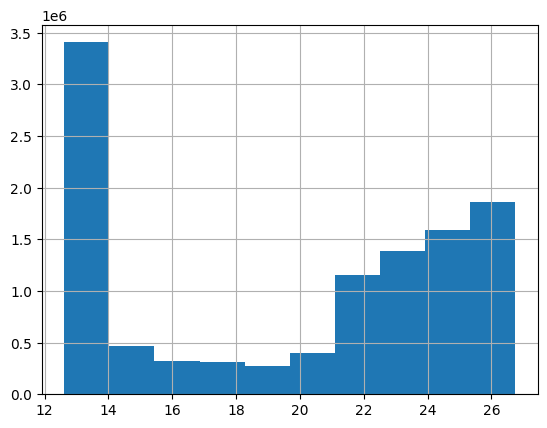

In [110]:
# f0의 분포를 보면, 일부 데이터의 밀도가 높긴 하지만 이진화처럼 범주형 변수로 변환하기에는 어려움이 있다.
train['f0'].hist()
plt.show()

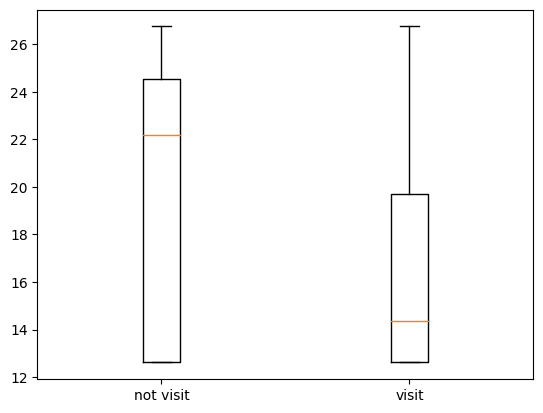

In [111]:
# f0의 경우, 전환이 이뤄지지 않을 때의 f0 IQR이 더 넓다. 그리고 평균 값이 더 크다.
# 때문에 전환에 영향을 미치는 특징이라고 판단한다.
plt.boxplot([train[train['visit'] == 0]['f0'], train[train['visit'] == 1]['f0']])
plt.xticks([1, 2], ['not visit', 'visit'])
plt.show()

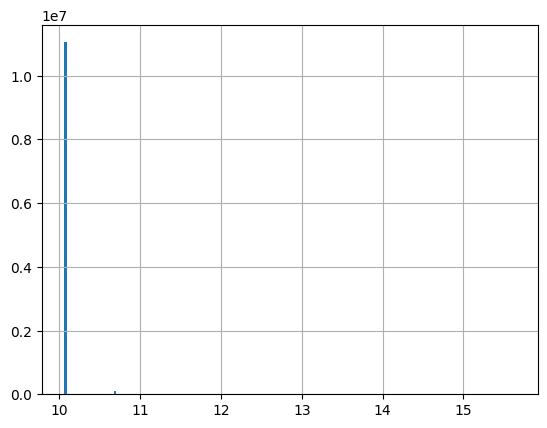

In [112]:
# f1의 분포
train['f1'].hist(bins=200)
plt.show()

In [113]:
# 특정 수치에 몰려있다.
# 그래서 가장 많이 나타나는 값과 아닌 값으로 이진화할 때, 전환율에 영향을 주는지 확인한다.
train['f1'].value_counts()

10.1    11046128
10.7       98495
11.1       21441
11.5        7681
11.7        3719
12.0        1931
12.2        1190
12.4         785
12.5         534
12.7         401
12.8         289
12.9         216
13.0         162
13.1         131
13.2         124
13.3          75
13.4          60
13.6          42
13.5          40
13.7          30
13.7          27
13.8          23
13.9          16
13.9          16
14.1          13
14.1          11
14.0          11
14.0          10
14.3           8
14.4           7
14.3           6
14.4           5
14.2           5
14.2           4
14.6           4
14.8           3
14.9           2
14.6           2
15.0           2
14.7           2
14.5           2
14.7           2
15.4           2
14.6           2
15.3           2
15.5           1
15.6           1
15.1           1
15.0           1
15.1           1
14.7           1
14.9           1
15.5           1
15.6           1
15.6           1
15.1           1
14.5           1
Name: f1, dtype: int64

In [114]:
f1_frequent_value = train['f1'].value_counts().index[0]
f1_frequent_value

10.059654474774549

In [115]:
train['f1_frequent'] = (train['f1'] == f1_frequent_value).astype(int)
train['f1_frequent'].value_counts()

1    11046128
0      137545
Name: f1_frequent, dtype: int64

In [116]:
# f1 frequent value가 전환에 미치는 영향을 살펴본다.
# 자주 나타나는 값이냐 아니냐에 따라 전환에 미치는 영향이 크다.
# f1을 자주 나타나는 값이냐 아니냐의 이진화 변수로 변환한다.
train.groupby(['f1_frequent'])['visit'].mean()

f1_frequent
0   0.3
1   0.0
Name: visit, dtype: float64

In [117]:
test['f1_frequent'] = (test['f1'] == f1_frequent_value).astype(int)
test['f1_frequent'].value_counts()

1    2761514
0      34405
Name: f1_frequent, dtype: int64

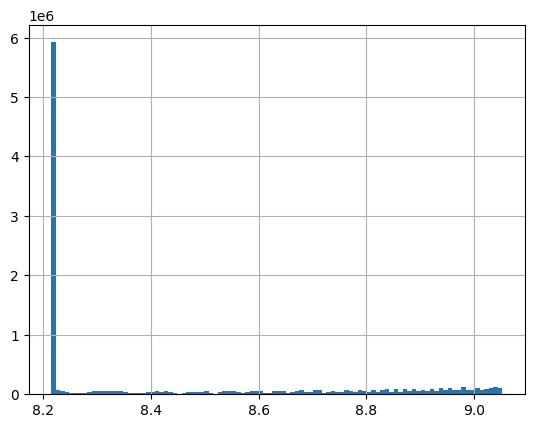

In [118]:
# f2의 분포
train['f2'].hist(bins=100)
plt.show()

In [119]:
train['f2'].value_counts()

8.2    5844356
8.2        144
8.2        125
8.2        120
8.2        111
        ...   
8.9          1
8.5          1
8.9          1
8.7          1
8.4          1
Name: f2, Length: 1925858, dtype: int64

In [120]:
f2_frequent_value = train['f2'].value_counts().index[0]
f2_frequent_value

8.214382844395335

In [121]:
train['f2_frequent'] = (train['f2'] == f2_frequent_value).astype(int)
train['f2_frequent'].value_counts()

1    5844356
0    5339317
Name: f2_frequent, dtype: int64

In [122]:
# f2 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f2_frequent'])['visit'].mean()

f2_frequent
0   0.1
1   0.0
Name: visit, dtype: float64

In [123]:
test['f2_frequent'] = (test['f2'] == f2_frequent_value).astype(int)
test['f2_frequent'].value_counts()

1    1459073
0    1336846
Name: f2_frequent, dtype: int64

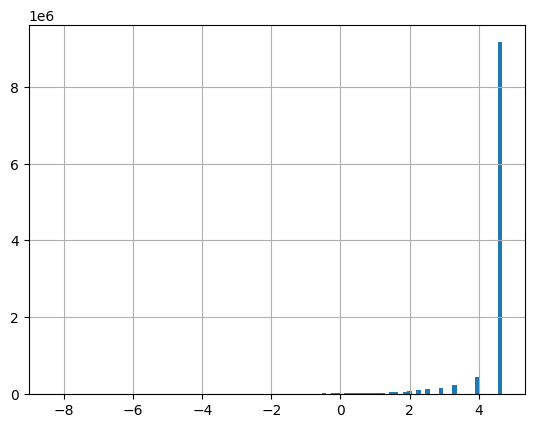

In [124]:
# f3의 분포
train['f3'].hist(bins=100)
plt.show()

In [125]:
train['f3'].value_counts()

4.7     9155411
3.9      459312
3.4      247153
2.9      171781
2.6      129561
         ...   
-6.4          1
-7.7          1
-5.9          1
-5.7          1
-5.7          1
Name: f3, Length: 523, dtype: int64

In [126]:
f3_frequent_value = train['f3'].value_counts().index[0]
f3_frequent_value

4.679881620097284

In [127]:
train['f3_frequent'] = (train['f3'] == f3_frequent_value).astype(int)
train['f3_frequent'].value_counts()

1    9155411
0    2028262
Name: f3_frequent, dtype: int64

In [128]:
# f3 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f3_frequent'])['visit'].mean()

f3_frequent
0   0.1
1   0.0
Name: visit, dtype: float64

In [129]:
test['f3_frequent'] = (test['f3'] == f3_frequent_value).astype(int)
test['f3_frequent'].value_counts()

1    2288584
0     507335
Name: f3_frequent, dtype: int64

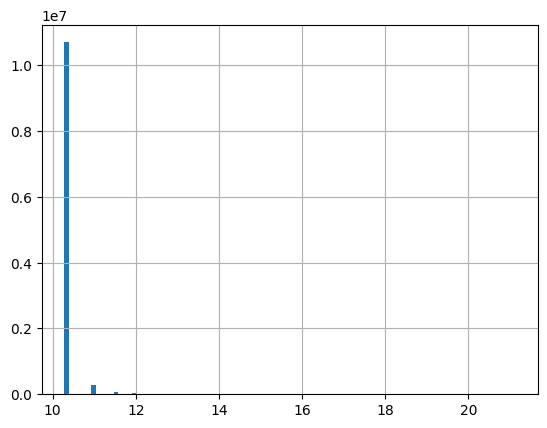

In [130]:
# f4의 분포
train['f4'].hist(bins=100)
plt.show()

In [131]:
train['f4'].value_counts()

10.3    10697712
11.0      278142
11.6       79077
12.0       36468
12.3       20825
          ...   
18.6           1
19.4           1
19.7           1
19.3           1
19.1           1
Name: f4, Length: 248, dtype: int64

In [132]:
f4_frequent_value = train['f4'].value_counts().index[0]
f4_frequent_value

10.280525225748212

In [133]:
train['f4_frequent'] = (train['f4'] == f4_frequent_value).astype(int)
train['f4_frequent'].value_counts()

1    10697712
0      485961
Name: f4_frequent, dtype: int64

In [134]:
# f4 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f4_frequent'])['visit'].mean()

f4_frequent
0   0.3
1   0.0
Name: visit, dtype: float64

In [135]:
test['f4_frequent'] = (test['f4'] == f4_frequent_value).astype(int)
test['f4_frequent'].value_counts()

1    2674983
0     120936
Name: f4_frequent, dtype: int64

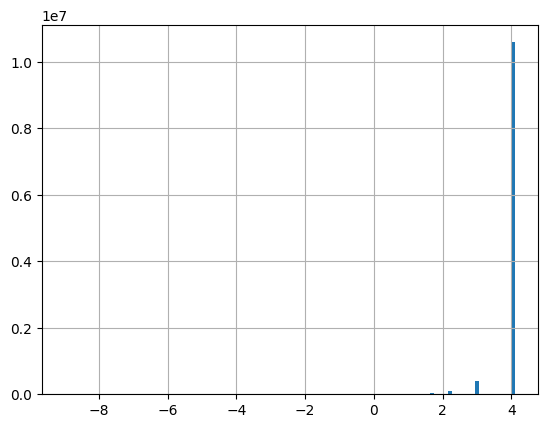

In [136]:
# f5의 분포
train['f5'].hist(bins=100)
plt.show()

In [137]:
train['f5'].value_counts()

4.1     10591129
3.0       386380
2.2       100242
1.6        41199
1.1        20983
          ...   
-6.8           1
-7.1           1
-9.0           1
-7.0           1
-7.7           1
Name: f5, Length: 127, dtype: int64

In [138]:
f5_frequent_value = train['f5'].value_counts().index[0]
f5_frequent_value

4.115453421277861

In [139]:
train['f5_frequent'] = (train['f5'] == f5_frequent_value).astype(int)
train['f5_frequent'].value_counts()

1    10591129
0      592544
Name: f5_frequent, dtype: int64

In [140]:
# f5 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f5_frequent'])['visit'].mean()

f5_frequent
0   0.2
1   0.0
Name: visit, dtype: float64

In [141]:
test['f5_frequent'] = (test['f5'] == f5_frequent_value).astype(int)
test['f5_frequent'].value_counts()

1    2647020
0     148899
Name: f5_frequent, dtype: int64

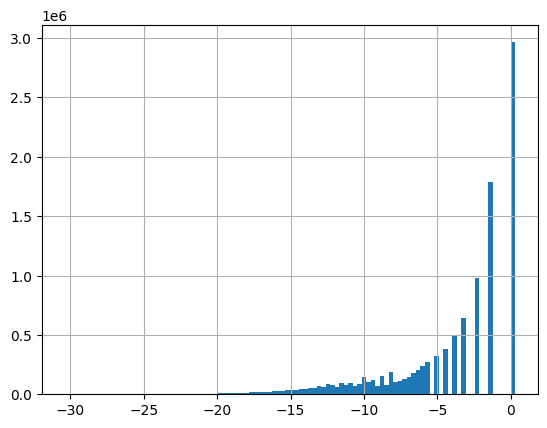

In [142]:
# f6의 분포
train['f6'].hist(bins=100)
plt.show()

In [143]:
# 이전에 진행했던 f 특징들과 다르게 데이터가 분포되어있다.
# 그래서 앞선 경우처럼 이진화를 진행하기에는 어려움이 있다.
train['f6'].value_counts()

0.3      2964272
-1.3     1786690
-2.4      980387
-3.3      644110
-4.0      496067
          ...   
-24.8          1
-25.4          1
-24.8          1
-25.0          1
-27.0          1
Name: f6, Length: 1574, dtype: int64

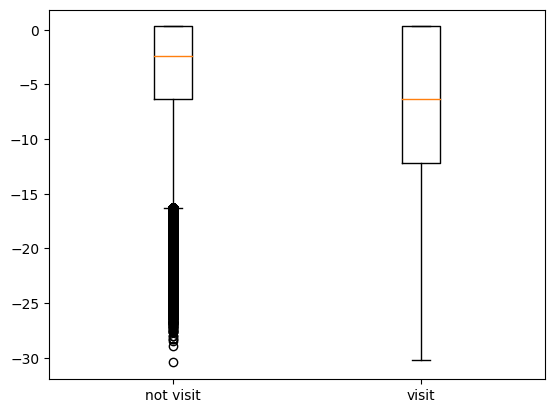

In [144]:
# f6의 경우, IQR 기준으로 전환이 이뤄지지 않은 f6의 이상치 값이 많다.
# 또한 전환이 이뤄지지 않은 경우에 평균이 낮고, 더 좁은 IQR 범위를 가지고 있다.
# 구분될 수 있는 특징이라 판단한다.
plt.boxplot([train[train['visit'] == 0]['f6'], train[train['visit'] == 1]['f6']])
plt.xticks([1, 2], ['not visit', 'visit'])
plt.show()

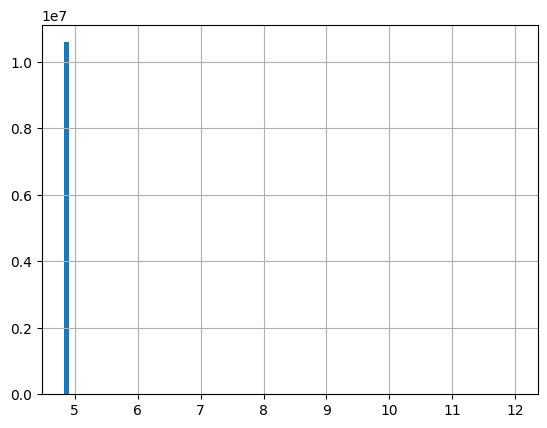

In [145]:
# f7의 분포
train['f7'].hist(bins=100)
plt.show()

In [146]:
train['f7'].value_counts()

4.8     10591129
6.5            6
10.2           6
7.7            5
8.8            5
          ...   
9.7            1
11.7           1
9.6            1
10.2           1
9.2            1
Name: f7, Length: 514349, dtype: int64

In [147]:
f7_frequent_value = train['f7'].value_counts().index[0]
f7_frequent_value

4.833814577796811

In [148]:
train['f7_frequent'] = (train['f7'] == f7_frequent_value).astype(int)
train['f7_frequent'].value_counts()

1    10591129
0      592544
Name: f7_frequent, dtype: int64

In [149]:
# f7 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f7_frequent'])['visit'].mean()

f7_frequent
0   0.2
1   0.0
Name: visit, dtype: float64

In [150]:
test['f7_frequent'] = (test['f7'] == f7_frequent_value).astype(int)
test['f7_frequent'].value_counts()

1    2647020
0     148899
Name: f7_frequent, dtype: int64

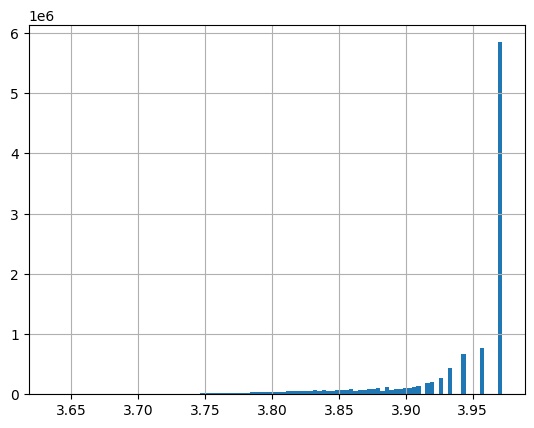

In [151]:
# f8의 분포
train['f8'].hist(bins=100)
plt.show()

In [152]:
# 이전에 진행했던 f 특징들과 다르게 데이터가 분포되어있다.
# 그래서 앞선 경우처럼 이진화를 진행하기에는 어려움이 있다.
train['f8'].value_counts()

4.0    5844356
4.0     765054
3.9     665272
3.9     428230
3.9     271183
        ...   
3.7          1
3.7          1
3.7          1
3.7          1
3.7          1
Name: f8, Length: 3575, dtype: int64

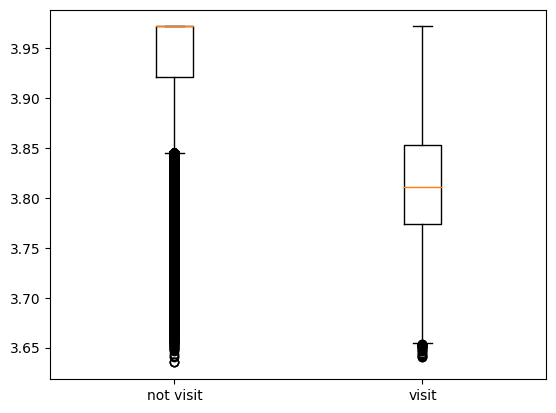

In [153]:
# f8의 경우, IQR 기준으로 전환이 이뤄지지 않은 f8의 이상치 값이 많다.
# 또한 전환이 이뤄지지 않은 경우에 평균이 낮고, 더 좁은 IQR 범위를 가지고 있다.
# 구분될 수 있는 특징이라 판단한다.
plt.boxplot([train[train['visit'] == 0]['f8'], train[train['visit'] == 1]['f8']])
plt.xticks([1, 2], ['not visit', 'visit'])
plt.show()

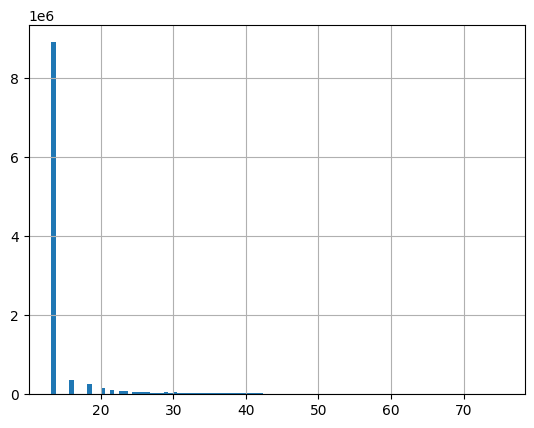

In [154]:
# f9의 분포
train['f9'].hist(bins=100)
plt.show()

In [155]:
train['f9'].value_counts()

13.2    8891584
16.2     364061
18.4     271649
20.1     159158
21.4     113115
         ...   
65.4          1
60.1          1
61.2          1
67.4          1
63.7          1
Name: f9, Length: 1526, dtype: int64

In [156]:
f9_frequent_value = train['f9'].value_counts().index[0]
f9_frequent_value

13.190055934673358

In [157]:
train['f9_frequent'] = (train['f9'] == f9_frequent_value).astype(int)
train['f9_frequent'].value_counts()

1    8891584
0    2292089
Name: f9_frequent, dtype: int64

In [158]:
# f9 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f9_frequent'])['visit'].mean()

f9_frequent
0   0.2
1   0.0
Name: visit, dtype: float64

In [159]:
test['f9_frequent'] = (test['f9'] == f9_frequent_value).astype(int)
test['f9_frequent'].value_counts()

1    2221751
0     574168
Name: f9_frequent, dtype: int64

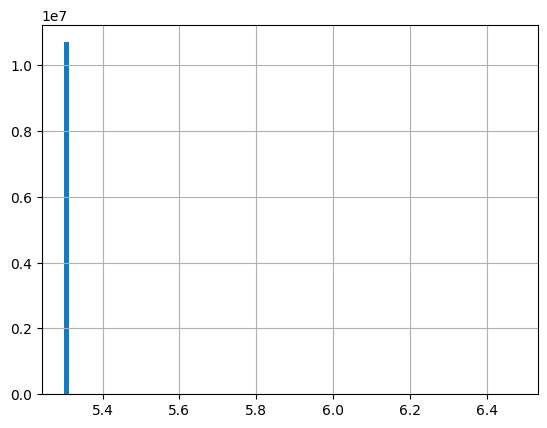

In [160]:
# f10의 분포
train['f10'].hist(bins=100)
plt.show()

In [161]:
train['f10'].value_counts()

5.3    10697712
6.3           9
5.8           8
6.3           8
6.1           8
         ...   
5.6           1
6.4           1
5.5           1
6.1           1
6.1           1
Name: f10, Length: 426829, dtype: int64

In [162]:
f10_frequent_value = train['f10'].value_counts().index[0]
f10_frequent_value

5.300374864042156

In [163]:
train['f10_frequent'] = (train['f10'] == f10_frequent_value).astype(int)
train['f10_frequent'].value_counts()

1    10697712
0      485961
Name: f10_frequent, dtype: int64

In [164]:
# f10 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f10_frequent'])['visit'].mean()

f10_frequent
0   0.3
1   0.0
Name: visit, dtype: float64

In [165]:
test['f10_frequent'] = (test['f10'] == f10_frequent_value).astype(int)
test['f10_frequent'].value_counts()

1    2674983
0     120936
Name: f10_frequent, dtype: int64

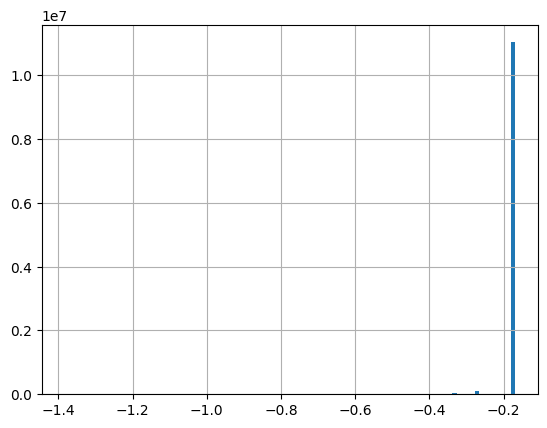

In [166]:
# f11의 분포
train['f11'].hist(bins=100)
plt.show()

In [167]:
train['f11'].value_counts()

-0.2    11021558
-0.3      102760
-0.3       24777
-0.4       10861
-0.4        6206
          ...   
-1.2           1
-1.3           1
-1.1           1
-1.1           1
-1.2           1
Name: f11, Length: 126, dtype: int64

In [168]:
f11_frequent_value = train['f11'].value_counts().index[0]
f11_frequent_value

-0.1686792210005612

In [169]:
train['f11_frequent'] = (train['f11'] == f11_frequent_value).astype(int)
train['f11_frequent'].value_counts()

1    11021558
0      162115
Name: f11_frequent, dtype: int64

In [170]:
# f11 frequent value가 전환에 미치는 영향을 살펴본다.
# 빈도수가 높은 값이냐 아니냐에 따라 전환에 미치는 영향이 크기에 이진 변수로 변환한다.
train.groupby(['f11_frequent'])['visit'].mean()

f11_frequent
0   0.4
1   0.0
Name: visit, dtype: float64

In [171]:
test['f11_frequent'] = (test['f11'] == f11_frequent_value).astype(int)
test['f11_frequent'].value_counts()

1    2755648
0      40271
Name: f11_frequent, dtype: int64

In [172]:
# 연속형 변수 f0 - f11 까지의 탐색 결과
# f0, f6, f8은 연속형 변수 유지
# 나머지 f(1, 2, 3, 4, 5, 7, 9, 10, 11)는 이진형 변수로 변환한다.

drop_feature_list = ['f1', 'f2', 'f3', 'f4', 'f5', 'f7', 'f9', 'f10', 'f11']
train = train.drop(drop_feature_list, axis=1)
test = test.drop(drop_feature_list, axis=1)

train.head()

,f0,f6,f8,treatment,conversion,visit,exposure,f1_frequent,f2_frequent,f3_frequent,f4_frequent,f5_frequent,f7_frequent,f9_frequent,f10_frequent,f11_frequent
2773177,17.1,-16.3,3.9,1,0,0,0,1,0,0,1,0,0,1,1,1
924024,13.8,-8.5,4.0,1,0,0,0,1,1,0,1,1,1,1,1,1
9648668,17.0,-8.5,4.0,1,0,0,0,1,1,0,1,1,1,1,1,1
2303695,12.6,0.3,3.9,1,0,0,0,1,0,1,1,1,1,1,1,1
831926,23.9,-1.3,4.0,1,0,0,0,1,1,1,1,1,1,1,1,1


##### 2. 이상치 제거

In [ ]:
# (*) TODO. IQR로 이상치를 제거하는데 생각보다 오랜 시간이 걸려서 진행을 했다고 가정하자.
# 이후에 전체적인 프로세스를 진행한 이후에 다시 여기로 와서 이상치를 제거하도록 하자.

##### 3. 특징간 관계 확인

In [173]:
train[['f0', 'f6', 'f8']].corr(method='pearson')

,f0,f6,f8
f0,1.0,-0.3,0.4
f6,-0.3,1.0,0.1
f8,0.4,0.1,1.0


In [ ]:
# 연속형 변수 중에서 (f0, f8)만이 0.4의 선형 상관성이 보인다.
# 큰 수치가 아니라 판단하고, 탐색을 계속해서 진행한다.

##### 4. 왜도 확인

In [174]:
# "f8"만 왜도 치우침의 기준인 1.5를 넘었다.
# 그래서 해당 특징에 대해서 변환을 통해 치우침을 줄인다.
train[['f0', 'f6', 'f8']].skew()

f0   -0.2
f6   -1.1
f8   -1.6
dtype: float64

In [175]:
import numpy as np

# log(x - x.min() + 1)
print(np.log(train['f8'] - train['f8'].min() + 1).skew()) # -1.6973350205225204

# sqrt(x - x.min())
print(np.sqrt(train['f8'] - train['f8'].min()).skew()) # -1.9015501235718548

-1.6984571266340531
-1.9028933024101473


In [ ]:
# log(x - x.min() + 1) / sqrt(x - x.min())
# 변환을 했지만, 오히려 치우침이 더 커졌다.
# 그래서 변환을 진행하지 않고, 판단의 기준인 1.5를 크게 넘어서지 않은 수치라서 그대로 유지한다.

##### 5. 스케일링

In [176]:
# f0, f6, f8 사이에 스케일 차이가 아래와 같이 발생한다.
# 그래서 추가적으로 스케일링 작업을 진행한다.
train[['f0', 'f6', 'f8']].max() - train[['f0', 'f6', 'f8']].min()

f0   14.1
f6   30.7
f8    0.3
dtype: float64

In [177]:
# 특징간 scale 차이가 크게 발생하기 때문에 이를 줄이기 위한 Min Max Scaler를 진행한다.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train[['f0', 'f6', 'f8']])

train[['f0', 'f6', 'f8']] = scaler.transform(train[['f0', 'f6', 'f8']])
train[['f0', 'f6', 'f8']].max() - train[['f0', 'f6', 'f8']].min()

f0   1.0
f6   1.0
f8   1.0
dtype: float64

In [178]:
test[['f0', 'f6', 'f8']] = scaler.transform(test[['f0', 'f6', 'f8']])

#### 타겟군 / 대조군 데이터 분할

In [179]:
# Uplift Modeling을 진행하기 위해서는 target(실험군) / control(대조군)의 비율이 1:1이 되어야 한다.
# 하지만, 현재 train dataset은 비율이 1:1이 아니다. 동일한 데이터셋을 맞추기 위해 언더 샘플링을 진행해야 한다.
train['exposure'].value_counts(normalize=True)

0   1.0
1   0.0
Name: exposure, dtype: float64

In [180]:
train['exposure'].value_counts()

0    10841103
1      342570
Name: exposure, dtype: int64

In [181]:
under_sample = train['exposure'].value_counts().iloc[1]
under_sample

342570

In [182]:
train_treatment = train[train['exposure'] == 1]
train_control = train[train['exposure'] == 0]

train_control_undersample = train_control.sample(under_sample)
train_treatment.shape, train_control_undersample.shape

((342570, 16), (342570, 16))

In [183]:
# 타겟군 학습 데이터 - train_treatment
# 대조군 학습 데이터 - train_control_undersample

# 타겟군 학습 데이터 생성
train_treatment_x = train_treatment.drop(['treatment', 'conversion', 'visit', 'exposure'], axis=1)
train_treatment_y = train_treatment['visit']

# 대조군 학습 데이터 생성
train_control_x = train_control_undersample.drop(['treatment', 'conversion', 'visit', 'exposure'], axis=1)
train_control_y = train_control_undersample['visit']

### 3. 업리프트 모델링

In [ ]:
# Two Model Approaches 를 사용하여, 타겟군 / 대조군 데이터를 각각 학습시켜 독립적인 두 모델을 생성한다.
# 학습이 모두 마무리되면, 결과값을 조합하여 최종 결과값을 산출한다.

In [184]:
train_treatment_x.shape, train_control_x.shape

((342570, 12), (342570, 12))

In [185]:
int(342570/12)

28547

In [186]:
# 특징 대비 샘플수가 충분하다. 28547 : 1
# 이진형과 연속형 데이터가 섞여있다.
# uplift score를 계산하기 위해 개별 클래스의 확률(predict_proba)을 출력하는 모델이어야 한다.
# > 그래서 적당한 복잡도를 가지는 LGBM 모델을 사용한다.

In [187]:
from lightgbm import LGBMClassifier

target_lgbm_model = LGBMClassifier(random_state=28)
target_lgbm_model.fit(train_treatment_x, train_treatment_y)

control_lgbm_model = LGBMClassifier(random_state=28)
control_lgbm_model.fit(train_control_x, train_control_y)

LGBMClassifier(random_state=28)

### 4. 실전 캠페인 적용 및 평가

In [188]:
import numpy as np
import pandas as pd

def set_group(score):
    if score < -0.1:
        group = 'sleeping dogs'
    elif score >= -0.1 and score < 0:
        group = 'lost causes'
    elif score >= 0 and score < 0.1:
        group = 'sure things'
    else:
        group = 'persuables'

    return group

def model_predict_conversion(prob):
    if prob >= 0.5:
        return 'visit'
    else:
        return 'not visit'

def get_result_df(test):
    drop_list = ['treatment', 'conversion', 'visit', 'exposure']
    test_x = test.drop(drop_list, axis=1)

    target_result = target_lgbm_model.predict_proba(test_x)[:, 1]
    control_result = control_lgbm_model.predict_proba(test_x)[:, 1]
    uplift_score_list = target_result - control_result

    result_df = pd.DataFrame({
    'user_id':test_x.index,
    'target_model_proba':target_result,
    'control_model_proba':control_result,
    'uplift_score':uplift_score_list})

    result_df['group'] = result_df['uplift_score'].apply(set_group)
    
    result_df['target_model_pred'] = result_df['target_model_proba'].apply(model_predict_conversion)
    result_df['control_model_pred'] = result_df['control_model_proba'].apply(model_predict_conversion)

    return result_df

def get_eval_df(result_df):
    # audience size
    eval_df = pd.DataFrame(result_df.groupby(['group'])['group'].count())
    eval_df.rename({'group':'audience_size'}, axis=1, inplace=True)

    # target model conversion prediction
    temp_df = result_df.groupby(['group'], as_index=False)['target_model_pred'].value_counts()
    temp_df = temp_df[temp_df['target_model_pred'] == 'visit']
    temp_df.rename({'count':'target_conversion_count'}, axis=1, inplace=True)
    temp_df = temp_df.set_index('group')

    # join eval_df / target model conversion prediction df
    eval_df = pd.concat([eval_df, temp_df['target_conversion_count']], axis=1)
    eval_df = eval_df.replace(np.nan, 0)
    eval_df['target_conversion_count'] = eval_df['target_conversion_count'].astype(int)

    # control model conversion prediction
    temp_df = result_df.groupby(['group'], as_index=False)['control_model_pred'].value_counts()
    temp_df = temp_df[temp_df['control_model_pred'] == 'visit']
    temp_df.rename({'count':'control_conversion_count'}, axis=1, inplace=True)
    temp_df = temp_df.set_index('group')

    # join eval_df / control model conversion prediction df
    eval_df = pd.concat([eval_df, temp_df['control_conversion_count']], axis=1)
    eval_df = eval_df.replace(np.nan, 0)
    eval_df['control_conversion_count'] = eval_df['control_conversion_count'].astype(int)

    # prediction difference between target and control
    eval_df['pred_diff'] = eval_df['target_conversion_count'] - eval_df['control_conversion_count']

    return eval_df

def not_apply_uplift(eval_df, cost_per_person, revenue_per_person):
    # 광고비
    num_people = eval_df['audience_size'].sum()
    ad_cost = num_people * cost_per_person

    # 전환수.
    conversion_count = eval_df['target_conversion_count'].sum()

    # 수익.
    revenue = conversion_count * revenue_per_person

    # 손실. 
    loss = eval_df[eval_df['pred_diff'] < 0]['pred_diff'].sum() * revenue_per_person
    loss = -loss

    # 이익
    profit = revenue - (ad_cost + loss)

    # ROAS
    roas = round(revenue * 100 / ad_cost)

    # ROI
    roi = round(profit * 100 / ad_cost)

    # 1인당 전환 단가
    conversion_cost_per_person = ad_cost / conversion_count

    result = [ad_cost, conversion_count, revenue, loss, profit, roas, roi, conversion_cost_per_person]
    return result

def apply_uplift(eval_df, cost_per_person, revenue_per_person):
    # 광고비
    num_people = eval_df.loc['persuables', 'audience_size']
    ad_cost = num_people * cost_per_person

    # 전환수.
    conversion_count = eval_df.loc['persuables', 'target_conversion_count']

    # 수익.
    revenue = conversion_count * revenue_per_person

    # 손실. 
    loss = 0

    # 이익
    profit = revenue - (ad_cost + loss)

    # ROAS
    roas = round(revenue * 100 / ad_cost)

    # ROI
    roi = round(profit * 100 / ad_cost)

    # 1인당 전환 단가
    conversion_cost_per_person = ad_cost / conversion_count

    result = [ad_cost, conversion_count, revenue, loss, profit, roas, roi, conversion_cost_per_person]
    return result

def get_eval_table(eval_df, cost_per_person, revenue_per_person):
    not_apply_list = not_apply_uplift(eval_df, cost_per_person, revenue_per_person)
    apply_list = apply_uplift(eval_df, cost_per_person, revenue_per_person)

    index_list = ['광고비', '전환수', '수익', '손실', '이익', 'ROAS', 'ROI', '1인당 전환 단가']
    eval_table = pd.DataFrame({'not_uplift':not_apply_list,
                               'uplift':apply_list},
                              index=index_list)
    
    return eval_table

In [189]:
result_df = get_result_df(test)
result_df.head()

,user_id,target_model_proba,control_model_proba,uplift_score,group,target_model_pred,control_model_pred
0,12195786,0.1,0.0,0.1,persuables,not visit,not visit
1,9561032,0.3,0.0,0.3,persuables,not visit,not visit
2,13909221,0.8,0.3,0.4,persuables,visit,not visit
3,3221612,0.1,0.0,0.1,sure things,not visit,not visit
4,6123086,0.3,0.0,0.3,persuables,not visit,not visit


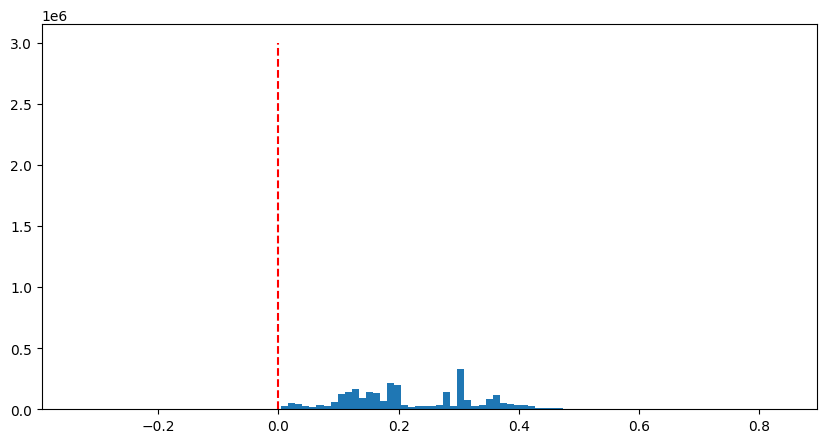

In [190]:
plt.hist(result_df['uplift_score'], bins=100)
plt.vlines(0, ymin=0, ymax=3000000, colors='r', linestyles='dashed')
plt.gcf().set_size_inches(10, 5)
plt.show()

In [191]:
eval_df = get_eval_df(result_df)
eval_df

,audience_size,target_conversion_count,control_conversion_count,pred_diff
group,,,,
lost causes,1149,18,22,-4
persuables,2498307,264578,34255,230323
sleeping dogs,143,1,6,-5
sure things,296320,137,129,8


In [192]:
pd.options.display.float_format = '{:.1f}'.format

cost_per_person = 100
revenue_per_person = 1000

eval_table = get_eval_table(
    eval_df, 
    cost_per_person, 
    revenue_per_person)

eval_table

,not_uplift,uplift
광고비,279591900.0,249830700.0
전환수,264734.0,264578.0
수익,264734000.0,264578000.0
손실,9000.0,0.0
이익,-14866900.0,14747300.0
ROAS,95.0,106.0
ROI,-5.0,6.0
1인당 전환 단가,1056.1,944.3


In [193]:
eval_df.to_csv('exposure_eval_df.csv')
eval_table.to_csv('exposure_eval_table.csv')

## 최종 결론
---

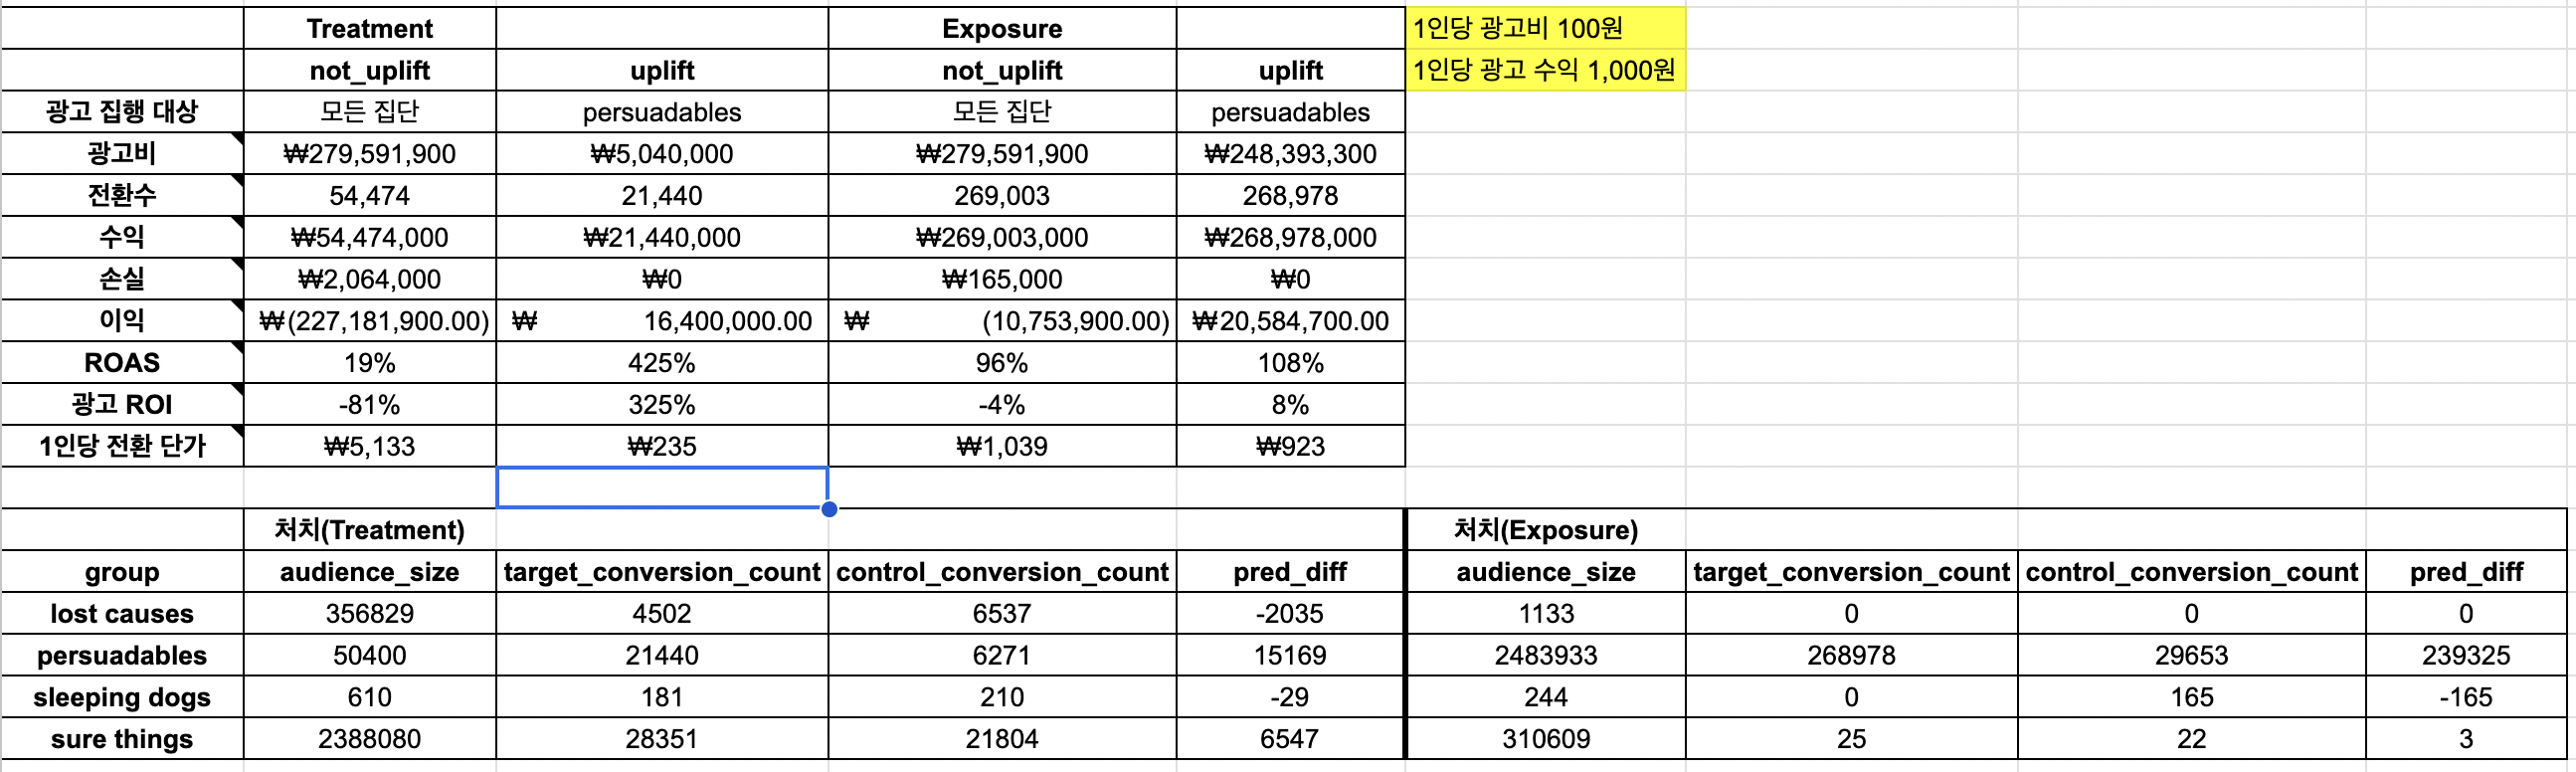

> **처치에 따른 수익** 
```
처치(Treatment / Exposure) 2가지 모두에 대해 모든 집단이 아닌 Persuadables 집단에만 처치하는 것이 더 좋은 수익을 거두었다. 
모든 집단에 대해서 처치할 경우에 오히려 손실이 발생했다. 
2가지 처치(Treatment / Exposure)는 각각 16,400,000 / 20,584,700 의 수익이 발생했다.
```

> **처치 여부에 따른 광고 효율 비교** 
```
광고 효율을 나타내는 지표로 ROAS, 1인당 전환 단가, ROI가 있다.
처치(Treatment / Exposure) 2가지 모두에 대해 모든 집단이 아닌 Persuadables 집단에만 처치하는 것이 더 좋은 광고 효율이 발생했다.
```  

> **Treatment / Exposure 수익 및 효율 비교** 
```
데이터 탐색 시에 Treatment가 이뤄졌지만, Exposure에 따라 전환에 미치는 영향이 컸다. 
처치를 Treatment가 아닌 Exposure에 대해서 진행할 경우에 약 400만원 가량의 수익이 더 발생했다. 
그래서 기업은 Treatment가 이뤄져도 효과적인 노출(Exposure)가 이뤄지게끔 해야 더 많은 수익을 기대할 수 있다.
```  